# Sustainable Bond Metrics

## Package Installation

In [1]:
import numpy as np  # NumPy numerical computing
import pandas as pd  # Pandas Data Analysis
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy import text

## Import Data

The different data points and the final database come from Bloomberg and Refinititv Workspace. Refer to the documentation on how to download the data from the two platforms. Pulling data for different instruments and different time ponts from Refinitiv Workspace requires the user to work with Excel. After creating the Excel file, the fallowing steps are used to create an SQL database and the data frame to work with in this Notebook.

In [2]:
# Define the connection parameters (as in the Dockerfile)
user = 'postgres'
password = 'sustainable'
db = 'sustainable_bonds_db'
host = 'db'
port = '5432'

# Create the connection URL
connection_url = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'
# Create the engine
engine = create_engine(connection_url)
# SQL query to retrieve data from the database
sql_query = 'SELECT * FROM bonds_table'

# Execute the SQL query and retrieve data into a Pandas DataFrame
df_AllBonds_postgres = pd.read_sql(sql_query, con=engine)
print(df_AllBonds_postgres)

        id                                        emittent   parent_id  \
0        1                                        Eviny AS  4296647386   
1        2                                   Vasakronan AB  4296675658   
2        3                                   Vasakronan AB  4298446161   
3        4                            Sonae Sierra SGPS SA  5000004887   
4        5                                     WindMW GmbH  5000036491   
...    ...                                             ...         ...   
4073  4074  Credit Agricole Corporate & Investment Bank SA     CAGR.PA   
4074  4075  Credit Agricole Corporate & Investment Bank SA     CAGR.PA   
4075  4076                          Erste Jelzalogbank zrt     ERST.VI   
4076  4077                          Erste Jelzalogbank zrt     ERST.VI   
4077  4078                                            None        None   

         identifier  sust_linked  ticker  social_bond  green_instrument  \
0        4296647386          0.0   B

Next, we replace some colum names (so that there are no more periods and spaces between the words) and see for the dates to write down the respective year (for easier referencing in the graphs). It also prints all the colum headings. 

In [3]:
# Ensure the Emissionsdatum is a datetime column
df_AllBonds_postgres['emissionsdatum'] = pd.to_datetime(df_AllBonds_postgres['emissionsdatum'])
df_AllBonds_postgres['year'] = df_AllBonds_postgres['emissionsdatum'].dt.year
# Apply the log transformation on the emission volume
df_AllBonds_postgres['Ausg_Mge_log'] = np.log(df_AllBonds_postgres['ausg_menge'])

df_AllBonds_postgres.columns

Index(['id', 'emittent', 'parent_id', 'identifier', 'sust_linked', 'ticker',
       'social_bond', 'green_instrument', 'sitzland', 'ausg_menge', 'maturity',
       'emissionsdatum', 'bics_level_1', 'kpn', 'faelligkeit', 'faell_typ',
       'waehrung', 'total_assets', 'tobinsq', 'roa', 'roe', 'lt_leverage',
       'trbc_es', 'cf_to_asset', 'year', 'Ausg_Mge_log'],
      dtype='object')

With this dataframe it is possible to do the analysis on how the market for sustainable bonds devolped over time, how the the different measurement channged and how the companies isssuing these instruments differ from another. Next we clean the data, to only include rows with complete data. If the analysis should be done including all rows, we can use 'df_AllBonds_clean' in our codes that follow.

In [4]:
# Create a new DataFrame by dropping the rows where at least one element is missing.
df_filtered = df_AllBonds_postgres.dropna()
df_filtered

,id,emittent,parent_id,identifier,sust_linked,ticker,social_bond,green_instrument,sitzland,ausg_menge,...,waehrung,total_assets,tobinsq,roa,roe,lt_leverage,trbc_es,cf_to_asset,year,Ausg_Mge_log
16,17,Westpac Securities NZ Ltd/London,4295856627,XS2016070430,0.0,WSTPNZ,0.0,1.0,GB,568150000.0,...,EUR,851875000000,0.117344,0.967960,13.571721,248.55563,Financials,0.003355,2019.0,20.157896
17,18,Brambles Finance PLC,4295856631,XS2596458591,0.0,BXBAU,0.0,1.0,GB,539750000.0,...,EUR,7496100000,1.854576,7.250113,20.422218,85.15272,Basic Materials,0.213179,2023.0,20.106617
18,19,CA Immobilien Anlagen AG,4295858951,CAIV.VI,0.0,CAIAV,0.0,1.0,AT,79269750.0,...,EUR,6820289000,0.569553,3.996450,8.331487,83.82042,Real Estate,0.022801,2022.0,18.188367
19,20,CA Immobilien Anlagen AG,4295858951,CAIV.VI,0.0,CAIAV,0.0,1.0,AT,79269750.0,...,EUR,6820289000,0.569553,3.996450,8.331487,83.82042,Real Estate,0.022801,2022.0,18.188367
20,21,CA Immobilien Anlagen AG,4295858951,CAIV.VI,0.0,CAIAV,0.0,1.0,AT,79269750.0,...,EUR,6820289000,0.569553,3.996450,8.331487,83.82042,Real Estate,0.022801,2022.0,18.188367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,4072,Credit Agricole Corporate & Investment Bank SA,CAGR.PA,Retrieving...,0.0,ACAFP,0.0,1.0,FR,17779800.0,...,EUR,1529294000000,0.022351,0.201272,4.208147,185.90393,Financials,-0.004159,2017.0,16.693574
4072,4073,Credit Agricole Corporate & Investment Bank SA,CAGR.PA,Retrieving...,0.0,ACAFP,0.0,1.0,FR,2267000.0,...,EUR,1524232000000,0.026001,0.221516,4.474541,212.92366,Financials,-0.014872,2018.0,14.633968
4073,4074,Credit Agricole Corporate & Investment Bank SA,CAGR.PA,Retrieving...,0.0,ACAFP,0.0,1.0,FR,589405.0,...,EUR,1524232000000,0.026608,0.173701,3.145714,212.92366,Financials,-0.014872,2018.0,13.286869
4074,4075,Credit Agricole Corporate & Investment Bank SA,CAGR.PA,Retrieving...,0.0,ACAFP,0.0,1.0,FR,10000000.0,...,USD,1551572000000,0.023100,0.282273,5.817528,199.98112,Financials,0.018585,2019.0,16.118096


## Descreptive Analysis

### Bond Measures

First, we want to look at the most important measures of the bonds, namly maturity, coupon and emission volume. First, we ensure that all values are numeric.

Second, we create a chart to see the developement of the market over the past years. As we can see, sustainable bonds are getting more and more popular (2022 was a difficult year for the whole bond market, as interest rates went up and the economic enviroment was difficult). With new data, this analysis can be done every year.

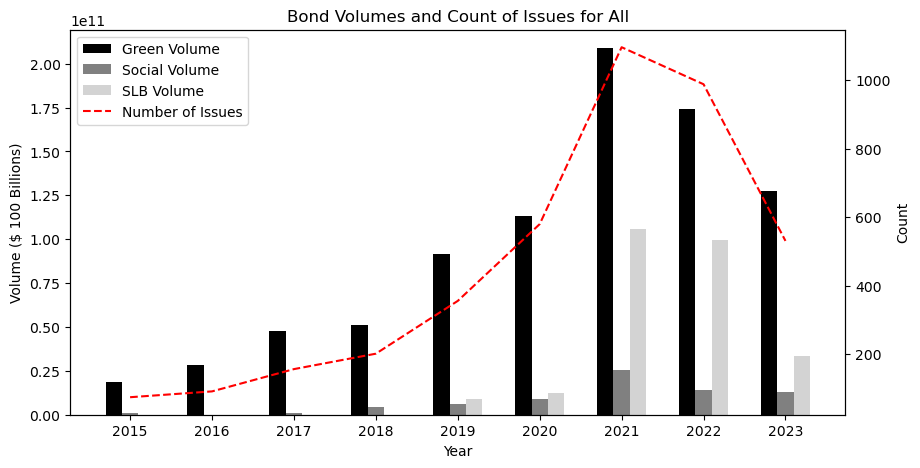

In [5]:
# Function to plot volumes and counts by country
def plot_bond_volumes_and_count_by_country(df, countries=None):
    if countries:
        df = df[df['sitzland'].isin(countries)]
    
    # Calculate volumes for green, social, and sustainable bonds and count of issues per year
    df['green_volume'] = df['green_instrument'] * df['ausg_menge']
    df['social_volume'] = df['social_bond'] * df['ausg_menge']
    df['sust_volume'] = df['sust_linked'] * df['ausg_menge']
    
    yearly_data = df.groupby('year').agg({
        'green_volume': 'sum',
        'social_volume': 'sum',
        'sust_volume': 'sum',
        'ticker': 'count'
    }).reset_index()
    
    # Create the bar plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.bar(yearly_data['year'] - 0.2, yearly_data['green_volume'], width=0.2, label='Green Volume', color='black')
    ax1.bar(yearly_data['year'], yearly_data['social_volume'], width=0.2, label='Social Volume', color='grey')
    ax1.bar(yearly_data['year'] + 0.2, yearly_data['sust_volume'], width=0.2, label='SLB Volume', color='lightgray')
    
    ax1.set_xticks(yearly_data['year'])
    
    # Create the line plot for count of issues
    ax2 = ax1.twinx()
    ax2.plot(yearly_data['year'], yearly_data['ticker'], label='Number of Issues', color='red', linestyle='--')
    
    # Labels & Title
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Volume ($ 100 Billions)')
    ax2.set_ylabel('Count')
    title_countries = 'All' if not countries else ', '.join(countries)
    plt.title(f'Bond Volumes and Count of Issues for {title_countries}')
    
    # Legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    plt.show()

# Call the function with your desired country codes
plot_bond_volumes_and_count_by_country(df_AllBonds_postgres)

In [6]:
# Change format for displayed numbers:
pd.options.display.float_format = '{:.2f}'.format

# Selecting specific columns for descriptive statistics
selected_columns = df_AllBonds_postgres[['ausg_menge', 'kpn','maturity']]

# Generating descriptive statistics and rounding
descriptive_stats = np.round(selected_columns.describe(), 2).T[['mean', 'std']]


descriptive_stats = descriptive_stats.map(lambda x: '{:,.2f}'.format(x))
# Display the statistics
latex_green = descriptive_stats.to_latex()

print(descriptive_stats)

                      mean             std
ausg_menge  300,412,618.24  348,381,822.70
kpn                   2.67            2.49
maturity              7.43           16.68


After seeing a general overview of the three indicators issue volume ("Ausg_Mge"), Coupon ("Kpn") and Maturity, we have look on how those indicators differ for the three products. Note that the total issue of green bond is bigger than the other two:

In [7]:
# List of columns to analyze
meas_to_analyze = ['ausg_menge','kpn','maturity']
# List of instruments
instruments = ['green_instrument', 'social_bond', 'sust_linked']

df_AllBonds_postgres[instruments].sum()

green_instrument   3301.00
social_bond         199.00
sust_linked         580.00
dtype: float64

From the graphs we can see that Sustainability Linked Bonds are clearly larger. To check if the differences are significant they should be normaly distributed, which in this case is not true (as seen in the Q-Q-Plots). 

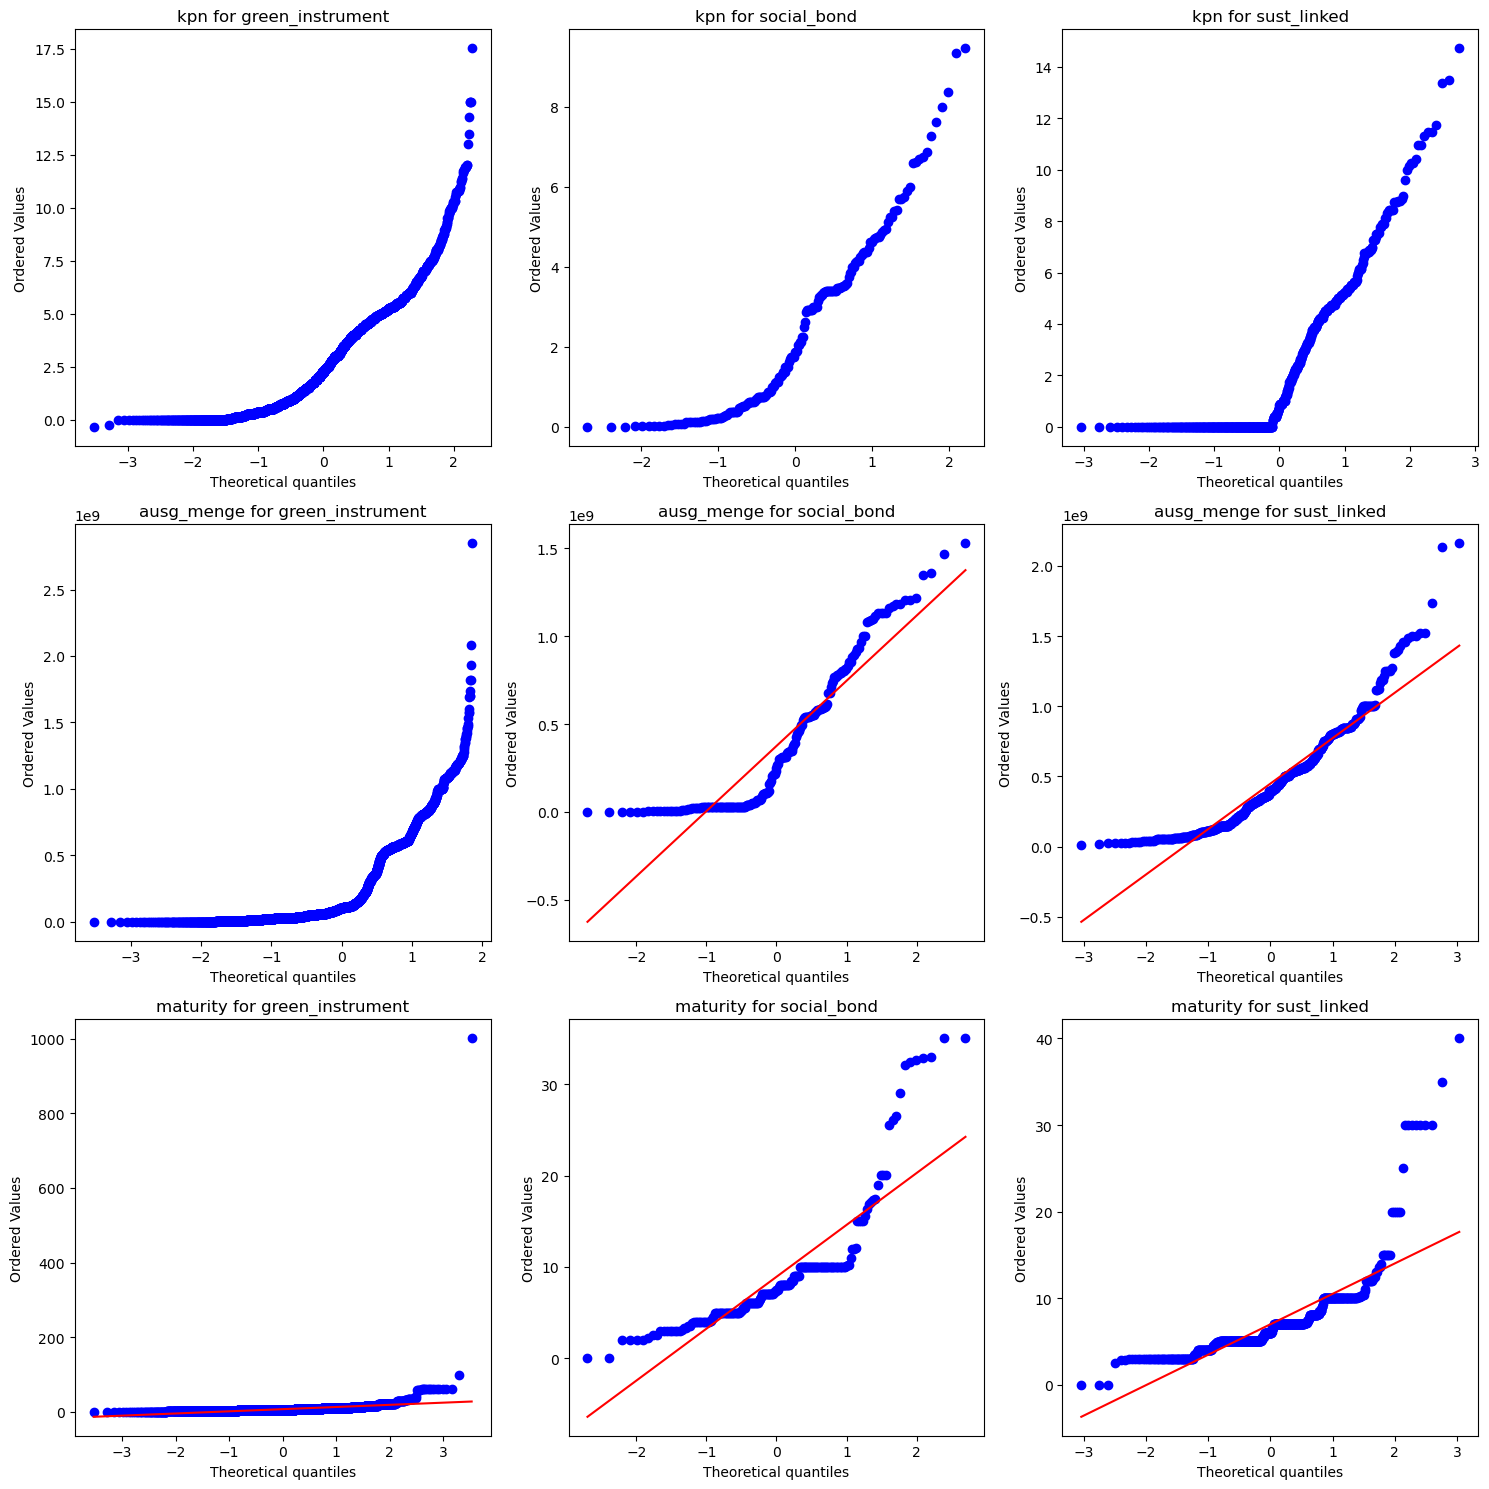

In [8]:
# List of measurements to analyze
meas_to_analyze = ['kpn', 'ausg_menge', 'maturity']
# List of instruments
instruments = ['green_instrument', 'social_bond', 'sust_linked']

# Create a figure and axes
fig, axs = plt.subplots(len(meas_to_analyze), len(instruments), figsize=(15, 15))

# Loop over each measurement to analyze
for i, meas in enumerate(meas_to_analyze):
    # Loop over each instrument
    for j, instrument in enumerate(instruments):
        # Filter the DataFrame for the current instrument
        df_filtered_instrument = df_AllBonds_postgres[df_AllBonds_postgres[instrument] == 1]
        
        # Create Q-Q plot
        stats.probplot(df_filtered_instrument[meas], plot=axs[i, j])
        
        # Set the title
        axs[i, j].set_title(f'{meas} for {instrument}')

# Show the plot
plt.tight_layout()
plt.show()

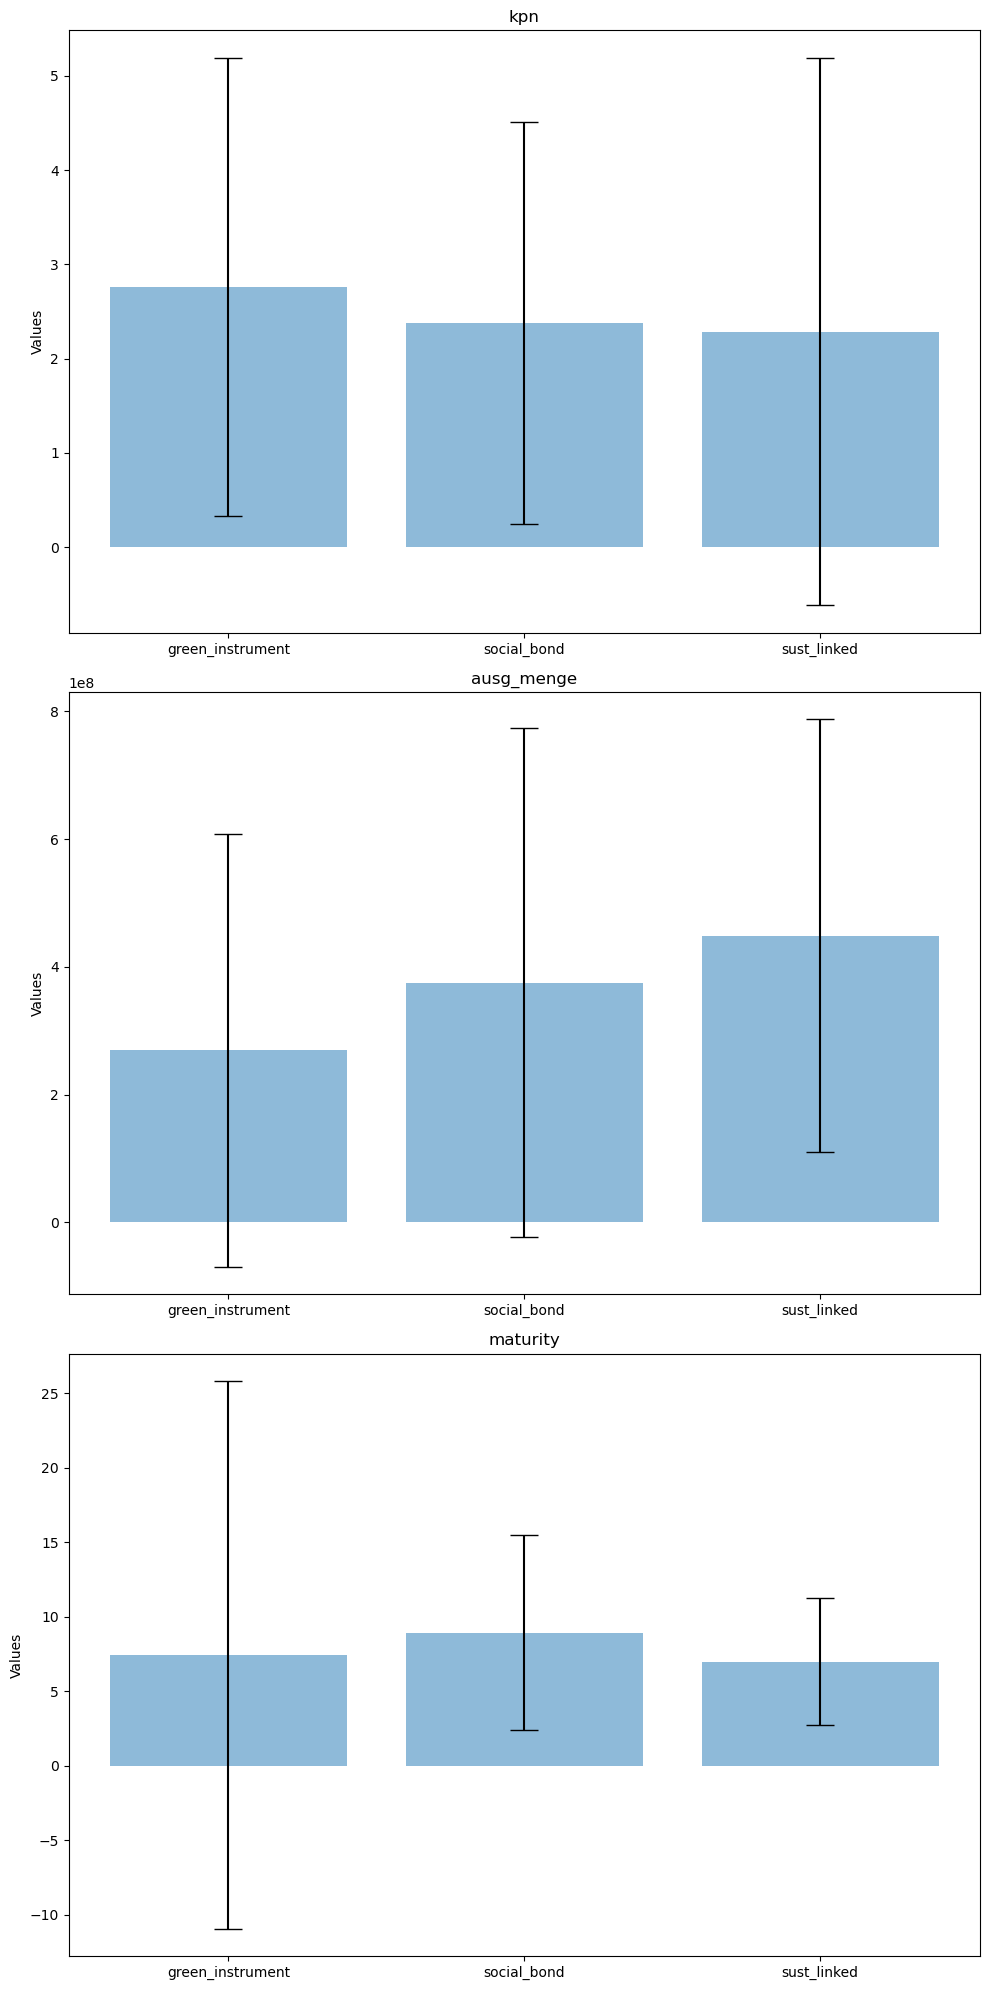

In [9]:
# Create a figure and axes
fig, axs = plt.subplots(len(meas_to_analyze), 1, figsize=(10, 20))

# Loop over each column to analyze
for i, col in enumerate(meas_to_analyze):
    # Initialize a list to store means and standard deviations for each instrument
    means = []
    stds = []
    
    # Loop over each instrument
    for instrument in instruments:
        # Filter the DataFrame for the current instrument
        df_filtered_instrument = df_AllBonds_postgres[df_AllBonds_postgres[instrument] == 1]
        
        # Calculate mean and standard deviation
        mean = df_filtered_instrument[col].mean()
        std = df_filtered_instrument[col].std()
        
        # Append to the lists
        means.append(mean)
        stds.append(std)
    
    # Create a bar plot for the mean with standard deviation as error bars
    axs[i].bar(instruments, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    axs[i].set_ylabel('Values')
    axs[i].set_title(f'{col}')

# Show the plot
plt.tight_layout()
plt.show()

Next, we analyze the developement of the indicators of the instruments over time: We see that green bonds have a lower volume but higher coupon which supports current literature that states, that SLBs profit form a high "Greenium" (mainly driven due to their popularity). Important note: it is not entirely correct to just take the coupon and compare them over different countries, as they have a different interest rate niveau. A next step would be to calculate the spread to the risk free rate.

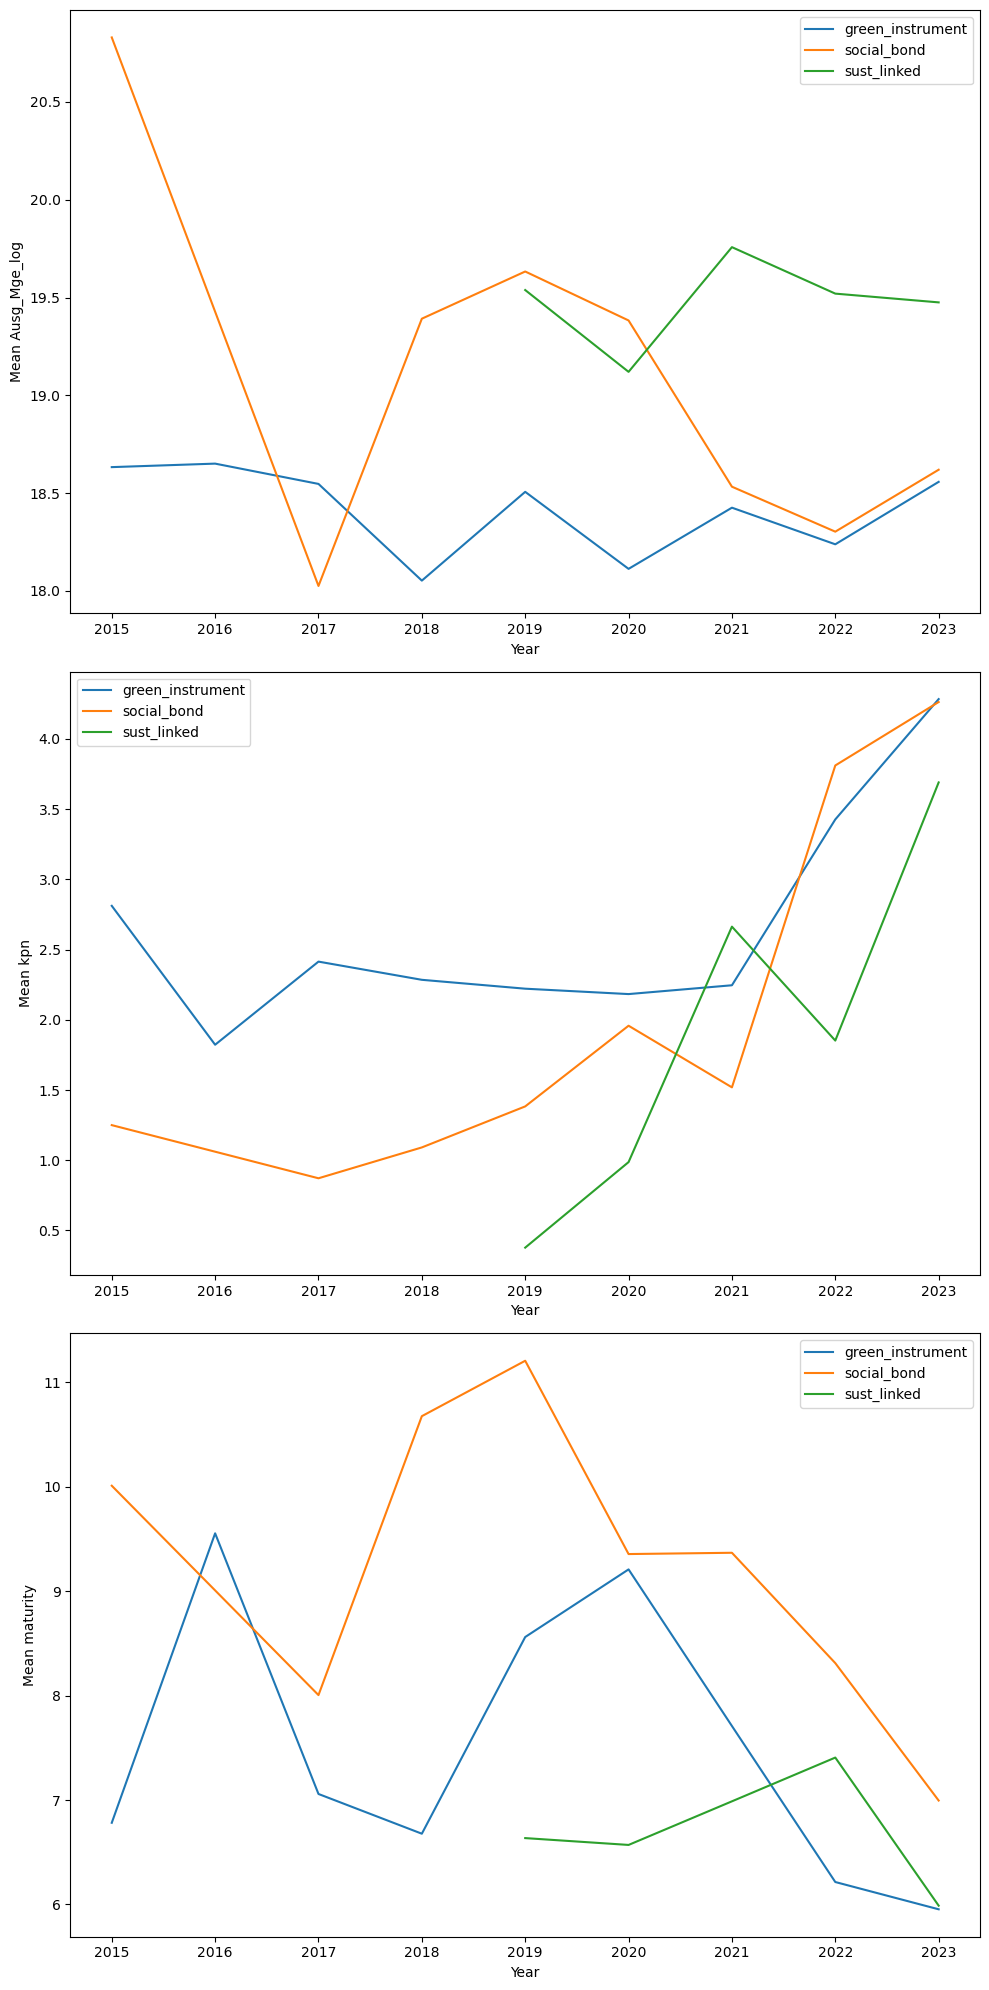

In [10]:
# List of columns to analyze
meas_to_analyze = ['Ausg_Mge_log','kpn','maturity']

# List of instruments
instruments = ['green_instrument', 'social_bond', 'sust_linked']

# Create a figure and axes
fig, axs = plt.subplots(len(meas_to_analyze), 1, figsize=(10, 20))

# Loop over each column to analyze
for i, col in enumerate(meas_to_analyze):
    # Loop over each instrument
    for instrument in instruments:
        # Filter the DataFrame for the current instrument
        df_instrument = df_AllBonds_postgres[df_AllBonds_postgres[instrument] == 1]
        
        # Group by year and calculate mean
        means = df_instrument.groupby('year')[col].mean()
        
        # Create a line plot for the mean
        axs[i].plot(means.index, means.values, label=instrument)
    
    axs[i].set_ylabel('Mean ' + col)
    axs[i].set_xlabel('Year')
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
# Calculate the distribution of elements in the 'FällTyp' column
distribution = df_AllBonds_postgres['faell_typ'].value_counts()

# Calculate the percentage distribution
percentage_distribution = (distribution / len(df_AllBonds_postgres)) * 100

# Print the result
print(percentage_distribution)

faell_typ
AT MATURITY     63.93
CALLABLE        32.07
SINKABLE         1.84
PERP/CALL        1.01
CONVERTIBLE      0.37
CALL/SINK        0.27
EXTENDIBLE       0.20
CALL/PUT         0.10
PERP/CALL/PUT    0.07
PUTABLE          0.05
PASS-THRU        0.02
CALL/EXT         0.02
CONV/PUT         0.02
Name: count, dtype: float64


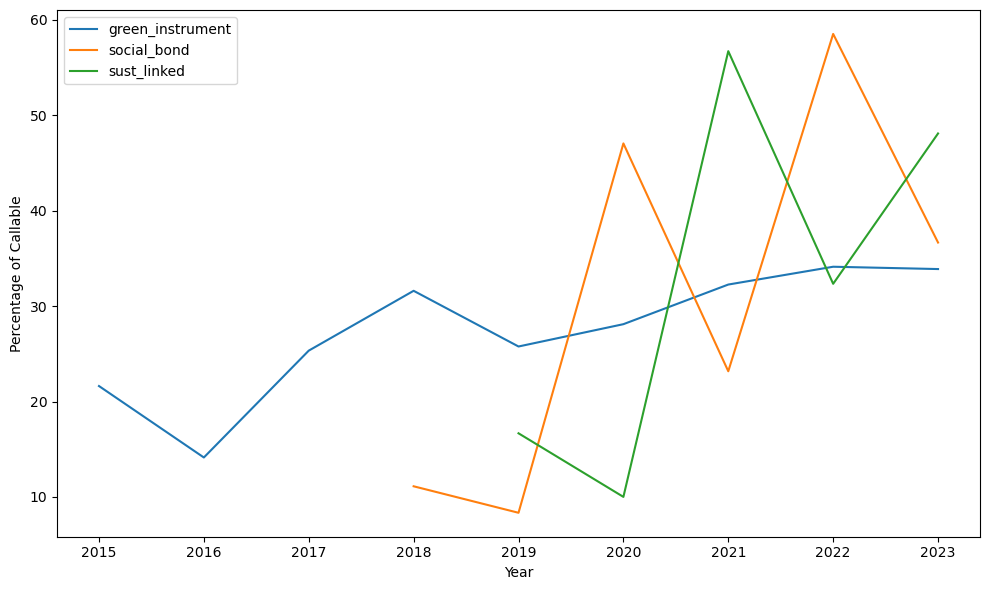

In [12]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each instrument
for instrument in instruments:
    # Filter the DataFrame for the current instrument
    df_instrument = df_AllBonds_postgres[df_AllBonds_postgres[instrument] == 1]
    
    # Filter for 'Callable' FällTyp
    df_callable = df_instrument[df_instrument['faell_typ'] == 'CALLABLE']
    
    # Group by year and calculate the percentage
    percentage_callable = (df_callable.groupby('year').size() / df_instrument.groupby('year').size()) * 100
    
    # Create a line plot for the percentage
    ax.plot(percentage_callable.index, percentage_callable.values, label=instrument)

ax.set_ylabel('Percentage of Callable')
ax.set_xlabel('Year')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Company Data

In [13]:
num_unique_ParentID = df_filtered['parent_id'].nunique()
print("Number of unique elements in 'parent_id':", num_unique_ParentID)

# Number of unique 'ParentID' where 'Sust_Linked' is equal to 1
num_unique_sust_linked = df_filtered[df_filtered['sust_linked'] == 1]['parent_id'].nunique()
print("Number of unique 'parent_id' where 'sust_linked' is 1:", num_unique_sust_linked)

# Number of unique 'ParentID' where 'Social_Bond' is equal to 1
num_unique_social_bond = df_filtered[df_filtered['social_bond'] == 1]['parent_id'].nunique()
print("Number of unique 'parent_id' where 'social_bond' is 1:", num_unique_social_bond)

# Number of unique 'ParentID' where 'Green_Instrument' is equal to 1
num_unique_green_instrument = df_filtered[df_filtered['green_instrument'] == 1]['parent_id'].nunique()
print("Number of unique 'parent_id' where 'green_instrument' is 1:", num_unique_green_instrument)

Number of unique elements in 'parent_id': 312
Number of unique 'parent_id' where 'sust_linked' is 1: 103
Number of unique 'parent_id' where 'social_bond' is 1: 18
Number of unique 'parent_id' where 'green_instrument' is 1: 225


In [14]:
# Get counts of unique values in 'TRBC_ES'
trbc_es_counts = df_filtered['trbc_es'].value_counts()

# Print the counts
print("Counts of unique values in 'TRBC_ES':\n", trbc_es_counts)

Counts of unique values in 'TRBC_ES':
 trbc_es
Financials                472
Real Estate               277
Industrials               250
Utilities                 202
Consumer Cyclicals         90
Basic Materials            86
Technology                 57
Consumer Non-Cyclicals     47
Energy                     23
Healthcare                 22
Name: count, dtype: int64


In [15]:
# Define the TRBC_ES value you're interested in
trbc_es_value = input("Choosen Industry: ")

# Check if the user wants to see all industries
if trbc_es_value.lower() == 'all':
    df_filtered_trbc_es = df_filtered
else:
    # Filter the DataFrame for the specified TRBC_ES value
    df_filtered_trbc_es = df_filtered[df_filtered['trbc_es'] == trbc_es_value]

# Group by 'Green_Instrument' and calculate descriptive statistics
green_stats = df_filtered_trbc_es[df_filtered_trbc_es['green_instrument'] == 1][['tobinsq', 'lt_leverage', 'cf_to_asset', 'roa', 'roe']].describe()

# Group by 'Social_Bond' and calculate descriptive statistics
social_stats = df_filtered_trbc_es[df_filtered_trbc_es['social_bond'] == 1][['tobinsq', 'lt_leverage', 'cf_to_asset','roa', 'roe']].describe()

# Group by 'Sust_Linked' and calculate descriptive statistics
sust_stats = df_filtered_trbc_es[df_filtered_trbc_es['sust_linked'] == 1][['tobinsq', 'lt_leverage','cf_to_asset', 'roa', 'roe']].describe()

# Print the statistics
print("Green Instrument Statistics:\n", green_stats)
print("\nSocial Bond Statistics:\n", social_stats)
print("\nSust Linked Statistics:\n", sust_stats)

Choosen Industry:  all


Green Instrument Statistics:
        tobinsq  lt_leverage  cf_to_asset     roa     roe
count  1181.00      1181.00      1181.00 1181.00 1181.00
mean      0.56       136.63         0.03    3.00   10.16
std       1.63       115.61         0.04    3.80    9.58
min       0.00         0.00        -0.27  -25.45  -38.56
25%       0.05        66.63         0.01    0.54    5.98
50%       0.27       116.57         0.03    2.00    9.13
75%       0.50       158.52         0.05    4.33   12.93
max      22.12      1016.25         0.21   20.22   65.38

Social Bond Statistics:
        tobinsq  lt_leverage  cf_to_asset   roa   roe
count    48.00        48.00        48.00 48.00 48.00
mean      0.18       127.94         0.03  2.21 10.96
std       0.23        62.88         0.05  2.71  7.50
min       0.01        14.90        -0.06  0.03 -1.23
25%       0.03        91.99        -0.00  0.36  6.13
50%       0.05       122.80         0.02  0.66  7.77
75%       0.27       140.22         0.06  4.98 14.14
max    

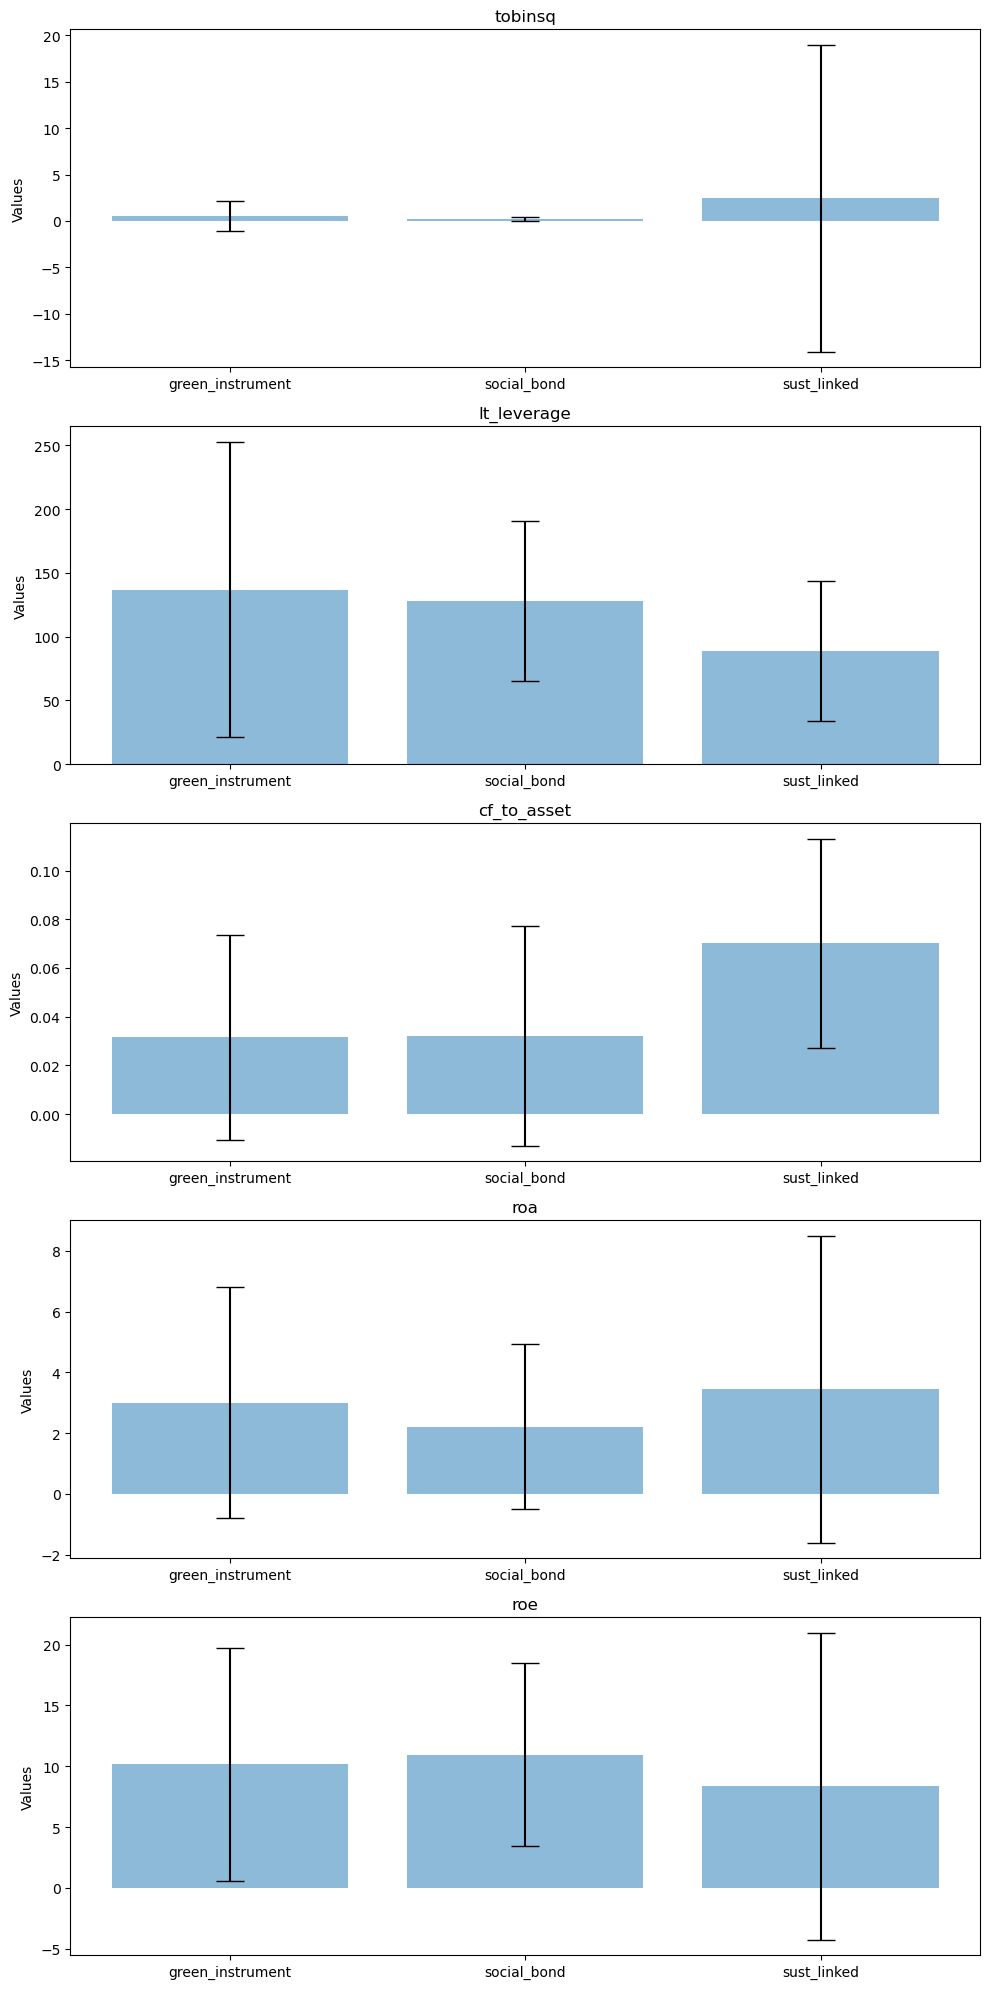

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to analyze
cols_to_analyze = ['tobinsq', 'lt_leverage', 'cf_to_asset', 'roa', 'roe']

# List of instruments
instruments = ['green_instrument', 'social_bond', 'sust_linked']

# Create a figure and axes
fig, axs = plt.subplots(len(cols_to_analyze), 1, figsize=(10, 20))

# Loop over each column to analyze
for i, col in enumerate(cols_to_analyze):
    # Initialize a list to store means and standard deviations for each instrument
    means = []
    stds = []
    
    # Loop over each instrument
    for instrument in instruments:
        # Filter the DataFrame for the current instrument
        df_instrument = df_filtered[df_filtered[instrument] == 1]
        
        # Calculate mean and standard deviation
        mean = df_instrument[col].mean()
        std = df_instrument[col].std()
        
        # Append to the lists
        means.append(mean)
        stds.append(std)
    
    # Create a bar plot for the mean with standard deviation as error bars
    axs[i].bar(instruments, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
    axs[i].set_ylabel('Values')
    axs[i].set_title(f'{col}')

# Show the plot
plt.tight_layout()
plt.show()

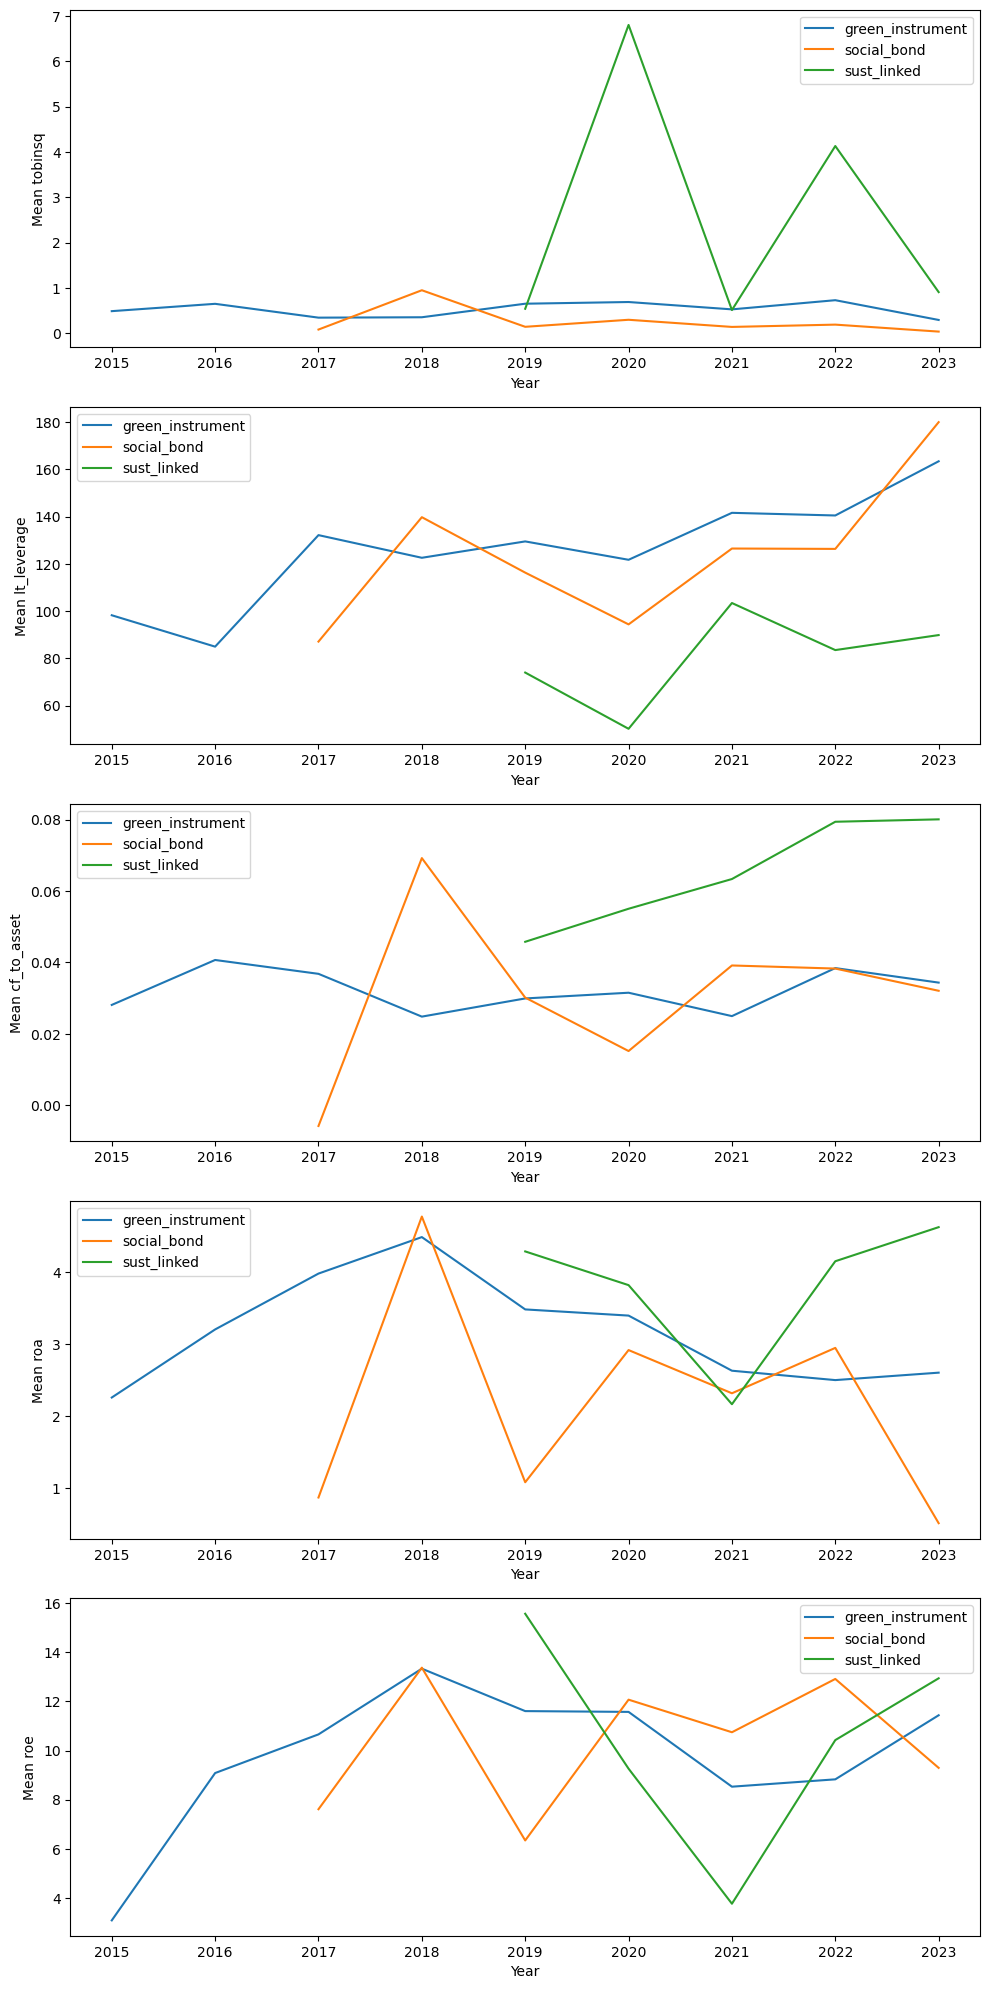

In [17]:
import matplotlib.pyplot as plt

# List of columns to analyze
cols_to_analyze = ['tobinsq', 'lt_leverage', 'cf_to_asset', 'roa', 'roe']

# List of instruments
instruments = ['green_instrument', 'social_bond', 'sust_linked']

# Create a figure and axes
fig, axs = plt.subplots(len(cols_to_analyze), 1, figsize=(10, 20))

# Loop over each column to analyze
for i, col in enumerate(cols_to_analyze):
    # Loop over each instrument
    for instrument in instruments:
        # Filter the DataFrame for the current instrument
        df_instrument = df_filtered[df_filtered[instrument] == 1]
        
        # Group by year and calculate mean
        means = df_instrument.groupby('year')[col].mean()
        
        # Create a line plot for the mean
        axs[i].plot(means.index, means.values, label=instrument)
    
    axs[i].set_ylabel('Mean ' + col)
    axs[i].set_xlabel('Year')
    axs[i].legend()

# Show the plot
plt.tight_layout()
plt.show()